# Описание набора данных

В датасете указан список станций Московского метрополитена, монорельса и МЦК по состоянию на 2017 год с их основными характеристиками.

Признак  | Описание
-------------------|--------------------
station_name       | Название станции
station_number       | Порядковый номер станции на линии
line_number       | Номер линии
line_number.alt       | Название линии
perehod | Наличие перехода на другую линию
perehod.alt | Описание перехода
depth | Глубина залегания, м
opening_date | Дата открытия
potok | Пассажиропоток
latitude | Широта
longitude | Долгота

# Загрузка и предварительная обработка данных

Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


Загрузим данные в датафрейм

In [2]:
df = pd.read_csv("Moscow_subway.csv", sep = ",", index_col = 0, header = 0, decimal = ".")
df

station_number line_number  \
station_name                                         
Сокольники                           4           1   
Красносельская                       5           1   
Комсомольская                        6           1   
Красные Ворота                       7           1   
Чистые пруды                         8           1   
...                                ...         ...   
Зорге                               26          14   
Панфиловская                        27          14   
Раменки                              1          8А   
Ломоносовский проспект               2          8А   
Минская                              3          8А   

                                      line_number.alt perehod  \
station_name                                                    
Сокольники                             Сокольническая     NaN   
Красносельская                         Сокольническая     NaN   
Комсомольская                          Сокольническая       5   
Красные Ворота                         Сокольническая     NaN   
Чистые пруды                           Сокольническая       6   
...                                               ...     ...   
Зорге                   Московское центральное кольцо     NaN   
Панфиловская            Московское центральное кольцо       7   
Раменки                                   Солнцевская     NaN   
Ломоносовский проспект                    Солнцевская     NaN   
Минская                                   Солнцевская     NaN   

                                                              perehod.alt  \
station_name                                                                
Сокольники                                                            NaN   
Красносельская                                                        NaN   
Комсомольская            Переход на станцию Комсомольская Кольцевой линии   
Красные Ворота                                                        NaN   
Чистые пруды            Переход на станцию Тургеневская Калужско-Рижск...   
...                                                                   ...   
Зорге                                                                 NaN   
Панфиловская            Переход на станцию Октябрьское поле Таганско-К...   
Раменки                                                               NaN   
Ломоносовский проспект                                                NaN   
Минская                                                               NaN   

                       depth opening_date    potok     latitude    longitude  
station_name                                                                  
Сокольники                -9   1935-05-15  75400.0  55,78888889  37,68027778  
Красносельская            -8   1935-05-15  25100.0        55,78  37,66722222  
Комсомольская             -8   1935-05-15  59000.0  55,77527778  37,65611111  
Красные Ворота           -31   1935-05-15  44000.0  55,76888889  37,64861111  
Чистые пруды             -35   1935-05-15  29200.0  55,76583333  37,63888889  
...                      ...          ...      ...          ...          ...  
Зорге                    NaN   2016-11-04      NaN  55,78916667  37,50416667  
Панфиловская             NaN   2016-11-08      NaN  55,79805556  37,49972222  
Раменки                  -15   2017-03-16      NaN  55,69611111  37,50527778  
Ломоносовский проспект   -15   2017-03-16      NaN  55,70555556      37,5225  
Минская                  -15   2017-03-16      NaN  55,72333333  37,50388889  

[243 rows x 10 columns]

Окинем взглядом основные статистики, посчитанные по данному набору данных.

In [3]:
df.describe()

station_number          potok
count      243.000000     199.000000
mean        10.868313   43311.055276
std          7.241349   26996.114168
min          1.000000    1000.000000
25%          5.000000   25850.000000
50%         10.000000   39400.000000
75%         16.500000   55850.000000
max         31.000000  181900.000000

Мы получили, что в таблице всего 2 столбца с данными. Однако это, разумеется, не так. В некоторых ячейках данные не были заданы, поэтому в них отображается $NaN$. Часть из этих ячеек пустует по очевидной причине: нет станции и линии, на которые можно перейти. В этом случае заменим $NaN$ на **Нет перехода** и $0$ соответственно. Если глубина заложения станции не задана, значит, это не подземное сооружение, а платформа МЦК. Чтобы не перепутать их с наземными станциями метро, зададим им глубину заложения $+1$ м. Однако строки, для которых неизвестен пассажиропоток, придётся удалить.

Удалим выбросы. Добавим побольше данных, приведя столбцы (в том числе с датой открытия станции) к числовому виду.
Посмотрим на то, что получилось.

In [4]:
clean_df = df.copy()
clean_df['perehod'].fillna(0, inplace=True)
clean_df['perehod.alt'].fillna('Нет перехода', inplace=True)
clean_df['depth'].fillna(1, inplace=True)
clean_df.dropna(axis=0, inplace=True)
clean_df['latitude'] = clean_df['latitude'].str.replace(',', '.')
clean_df['longitude'] = clean_df['longitude'].str.replace(',', '.')
clean_df['depth'] = clean_df['depth'].str.replace(',', '.')
clean_df['latitude'] = clean_df['latitude'].astype(float)
clean_df['longitude'] = clean_df['longitude'].astype(float)
clean_df['depth'] = clean_df['depth'].astype(float)
clean_df['opening_date'] = pd.to_datetime(clean_df['opening_date'])
clean_df['newness'] = (clean_df['opening_date'] - clean_df['opening_date'].min()).dt.days + 1
clean_df.describe()

station_number       depth                   opening_date  \
count      199.000000  199.000000                            199   
mean        10.572864  -21.500000  1975-08-09 18:27:08.140703520   
min          1.000000  -73.600000            1935-05-15 00:00:00   
25%          5.000000  -39.550000            1958-08-04 00:00:00   
50%         10.000000  -10.500000            1975-12-17 00:00:00   
75%         16.000000   -8.000000            1992-01-30 12:00:00   
max         25.000000   10.000000            2016-09-16 00:00:00   
std          6.580002   19.317684                            NaN   

               potok    latitude   longitude       newness  
count     199.000000  199.000000  199.000000    199.000000  
mean    43311.055276   55.733543   37.609761  14697.768844  
min      1000.000000   55.538056   37.354444      1.000000  
25%     25850.000000   55.689306   37.557083   8483.000000  
50%     39400.000000   55.745000   37.608889  14827.000000  
75%     55850.000000   55.778611   37.657639  20715.500000  
max    181900.000000   55.898056   37.863889  29711.000000  
std     26996.114168    0.073883    0.098495   8659.127745


Получаем семь столбцов вместо двух (однако используем только 6, потому что на замену **opening_date** пришла **newness**. Будем проводить операции с ними.

Теперь построим boxplot, чтобы посмотреть на разброс масштаба данных:





<Axes: >

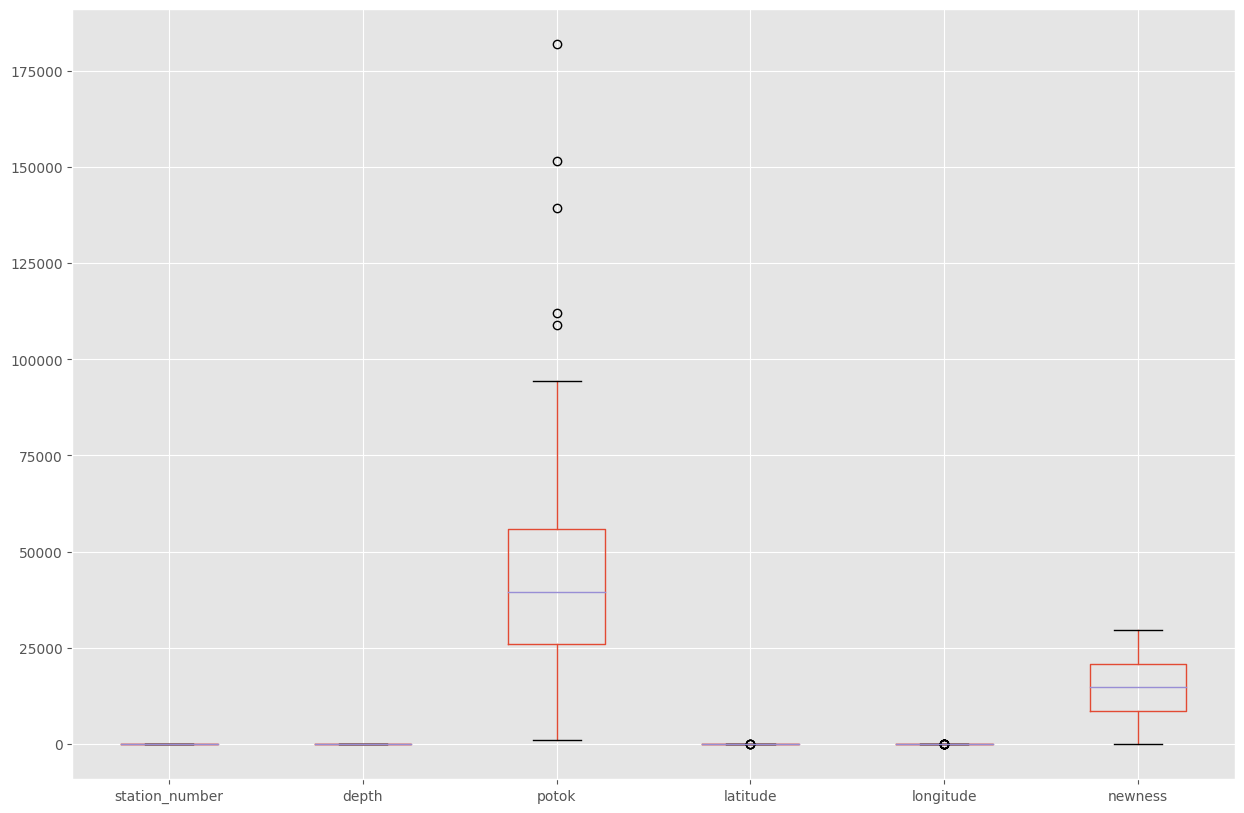

In [5]:
clean_df.boxplot(figsize=(15,10))

Рассматриваемые числовые величины имеют разный порядок, а значит, без сомнений, перед началом обработки их нужно стандартизировать. Будем стандартизировать с помощью MinMaxScaler(), поскольку в задаче хочется сохранить расстояние между датами открытия.



In [6]:
standard_scaler = MinMaxScaler()
float_df = clean_df[['station_number', 'depth', 'potok', 'latitude', 'longitude', 'newness']]
standard_df = pd.DataFrame(data = standard_scaler.fit_transform(float_df), index = float_df.index, columns = float_df.columns)
standard_df

station_number     depth     potok  latitude  \
station_name                                                          
Сокольники                   0.125000  0.772727  0.411277  0.696759   
Красносельская               0.166667  0.784689  0.133223  0.672068   
Комсомольская                0.208333  0.784689  0.320619  0.658951   
Красные Ворота               0.250000  0.509569  0.237700  0.641204   
Чистые пруды                 0.291667  0.461722  0.155887  0.632716   
...                               ...       ...       ...       ...   
Котельники                   0.916667  0.700957  0.099502  0.378086   
Технопарк                    0.541667  0.880383  0.105030  0.435957   
Румянцево                    0.833333  0.736842  0.138198  0.263889   
Саларьево                    0.875000  0.736842  0.193477  0.233025   
Петровско-Разумовская        0.000000  0.150718  0.343284  0.824846   

                       longitude   newness  
station_name                                
Сокольники              0.639586  0.000000  
Красносельская          0.613959  0.000000  
Комсомольская           0.592148  0.000000  
Красные Ворота          0.577426  0.000000  
Чистые пруды            0.558342  0.000000  
...                          ...       ...  
Котельники              0.989095  0.987849  
Технопарк               0.607961  0.991148  
Румянцево               0.171756  0.991855  
Саларьево               0.136859  0.992797  
Петровско-Разумовская   0.431843  1.000000  

[199 rows x 6 columns]

Снова взглянем на boxplot, чтобы убедиться, что теперь визуально все неплохо.

<Axes: >

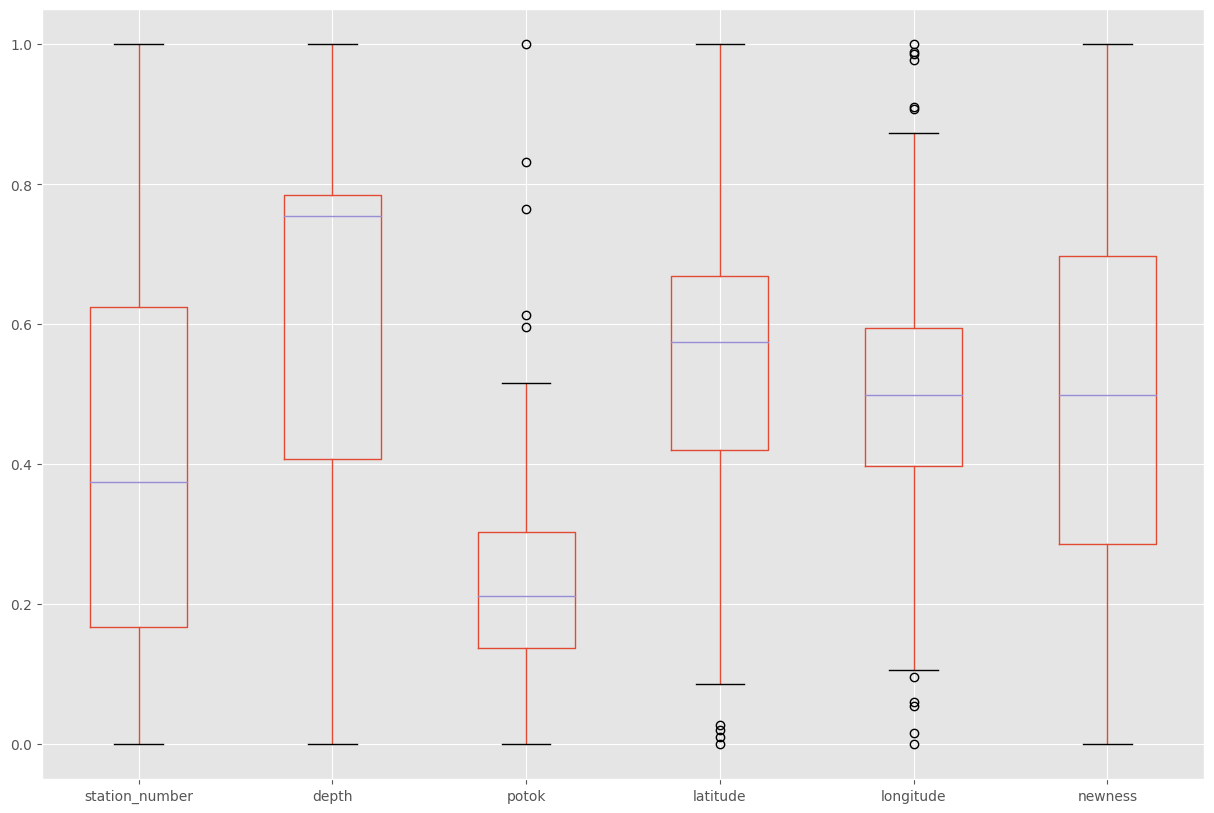

In [7]:
standard_df.boxplot(figsize=(15,10))

Мы видим, что теперь все величины имеют одинаковый порядок. Есть несколько станций с выбивающимся пассажиропотоком, а также слишком далёкие станции - но они выбросами не являются.

Проверим, правильно ли всё импортировалось. Построим точки в зависимости долготы от широты.

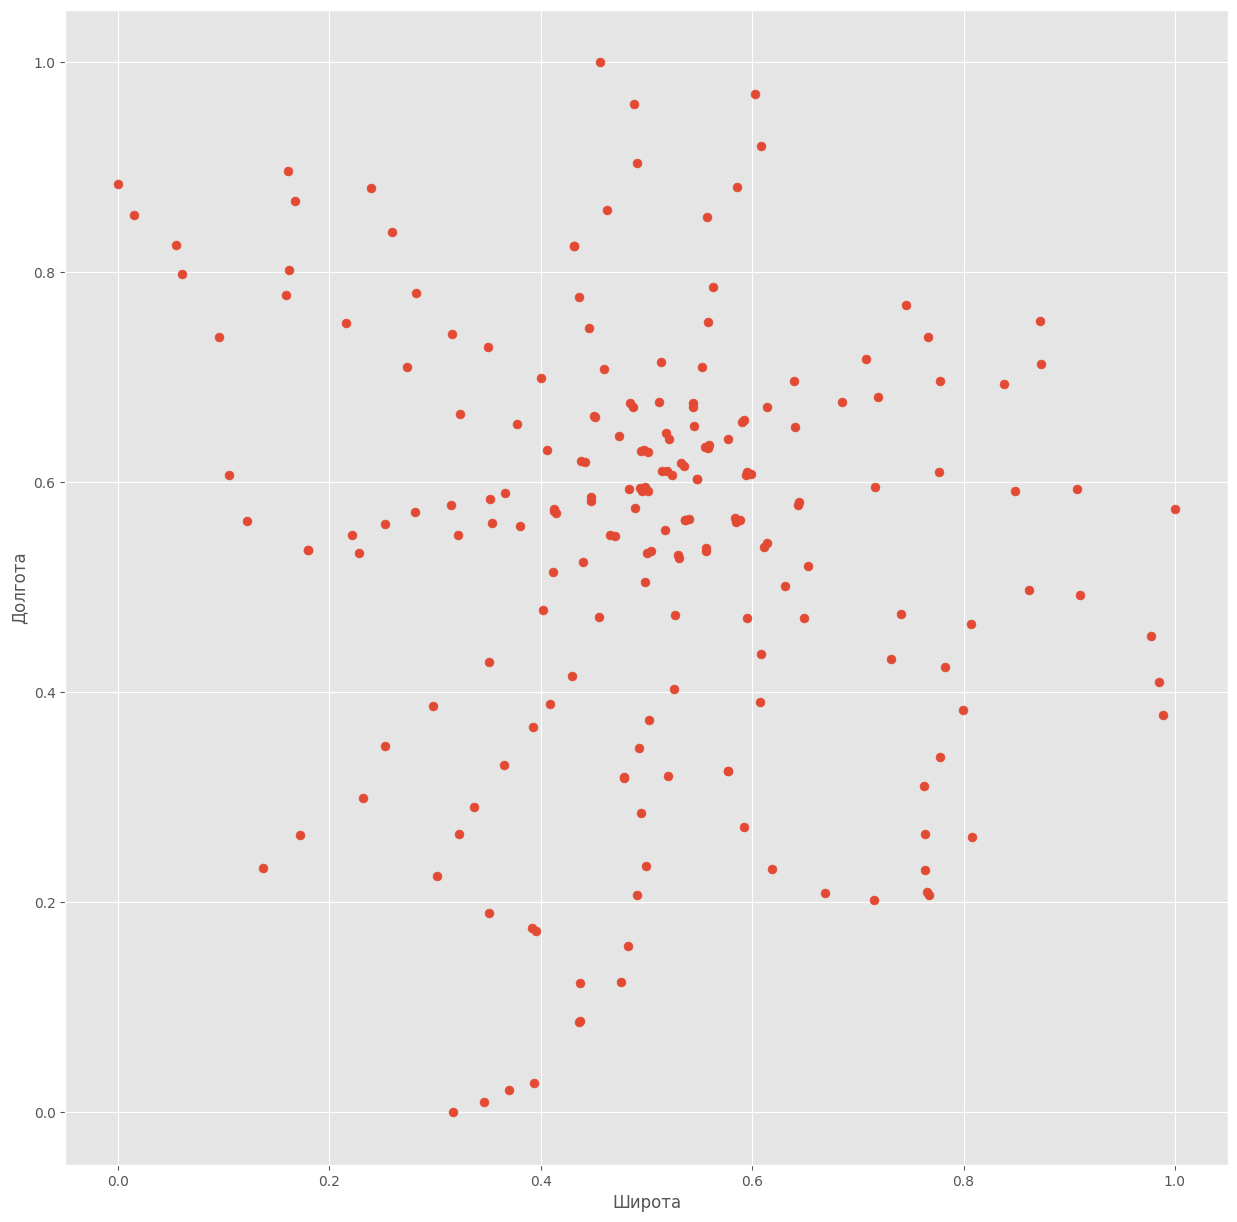

In [8]:
map = plt.figure(figsize=(15,15)).add_subplot(projection='rectilinear')
map.scatter(standard_df["longitude"], standard_df["latitude"], alpha = 1, s =40)
map.set_xlabel('Широта')
map.set_ylabel('Долгота')
plt.show()

Очевидно, это похоже на схему метро по состоянию на 2017 год: https://b1.m24.ru/c/989158.jpg

Теперь данные подготовлены.

# Постановка задачи и построение модели

Наша задача — выяснить, могут ли станции московского метро быть кластеризованы по основным параметрам и попытаться объяснить, чем обусловлена эта кластеризация (что за группы получились).

**Решим две задачи кластеризации и изучим:**
* Зависимость пассажиропотока на станции от места её расположения;
* Зависимость друг от друга трёх величин: пассажиропотока, глубины заложения станции и времени её постройки.

Для проведения кластеризации будем использовать метод k-means. Попытаемся определить адекватное число кластеров (изучим диапазон от 1 до 10).

In [9]:
first_df = float_df.copy()
first_df = first_df[['potok', 'latitude', 'longitude']]

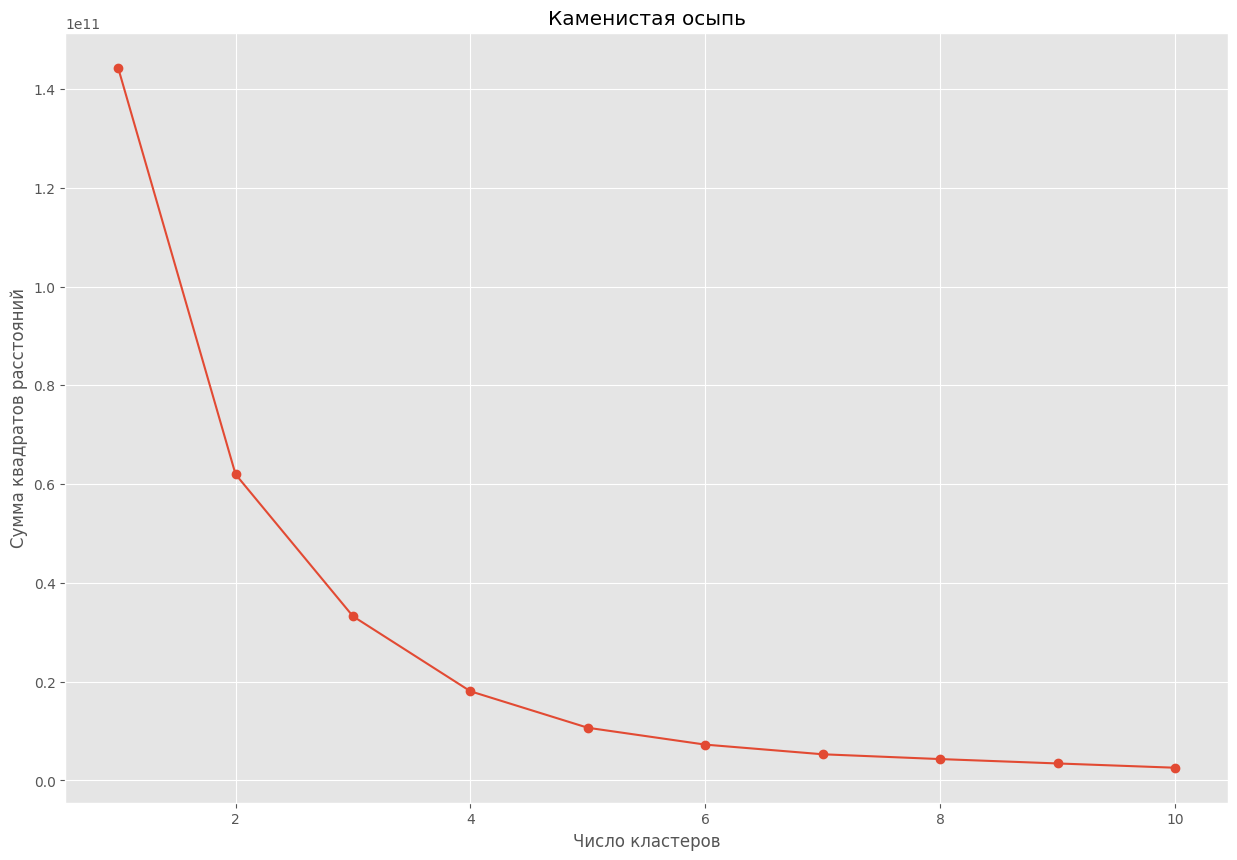

In [10]:
K = range(1, 11)
models = [KMeans(n_clusters = k, random_state = 111, n_init = 100, max_iter = 10000).fit(first_df) for k in K]
dist = [model.inertia_ for model in models]

plt.figure(figsize=(15,10))
plt.plot(K, dist, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Каменистая осыпь')
plt.show()

По графику видно, что имеет смысл рассмотреть диапазон от 2 до 6 кластеров. Далее излом не такой большой, а значит большее количество кластеров можно не брать в расчет.

# Кластеризация "пассажиропоток - координата"

Поскольку мы можем визуализировать только три оси, будем по очереди выбирать три признака. Начнём с двух координат и пассажиропотока. Нулевая гипотеза: чем ближе станция к центру, тем больше на ней пассажиров. Произведём кластеризацию для каждого случая и визуализируем полученные результаты.

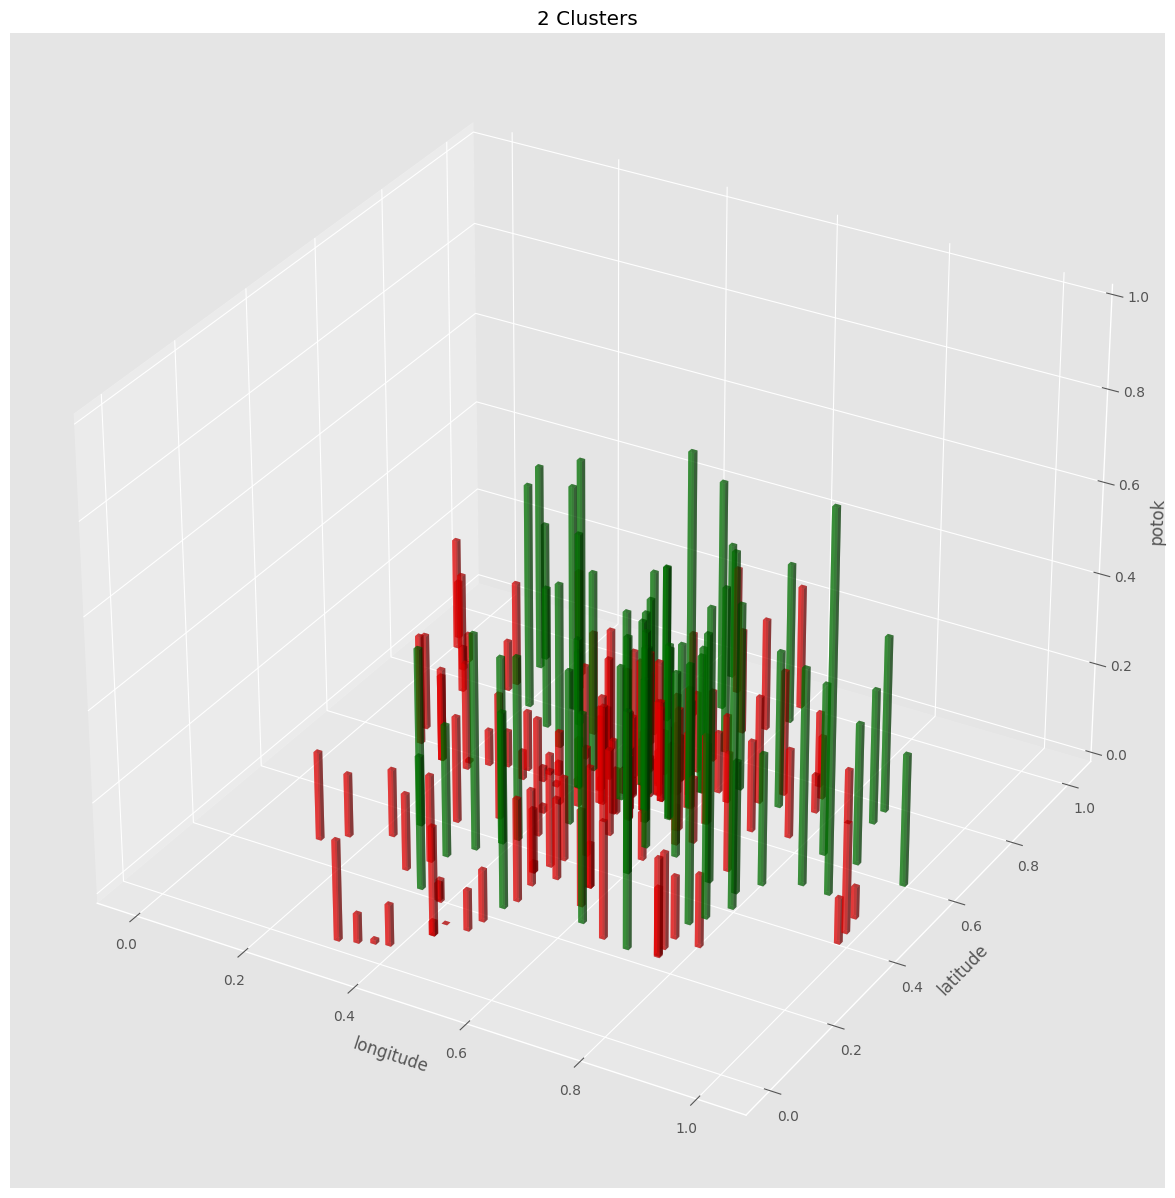

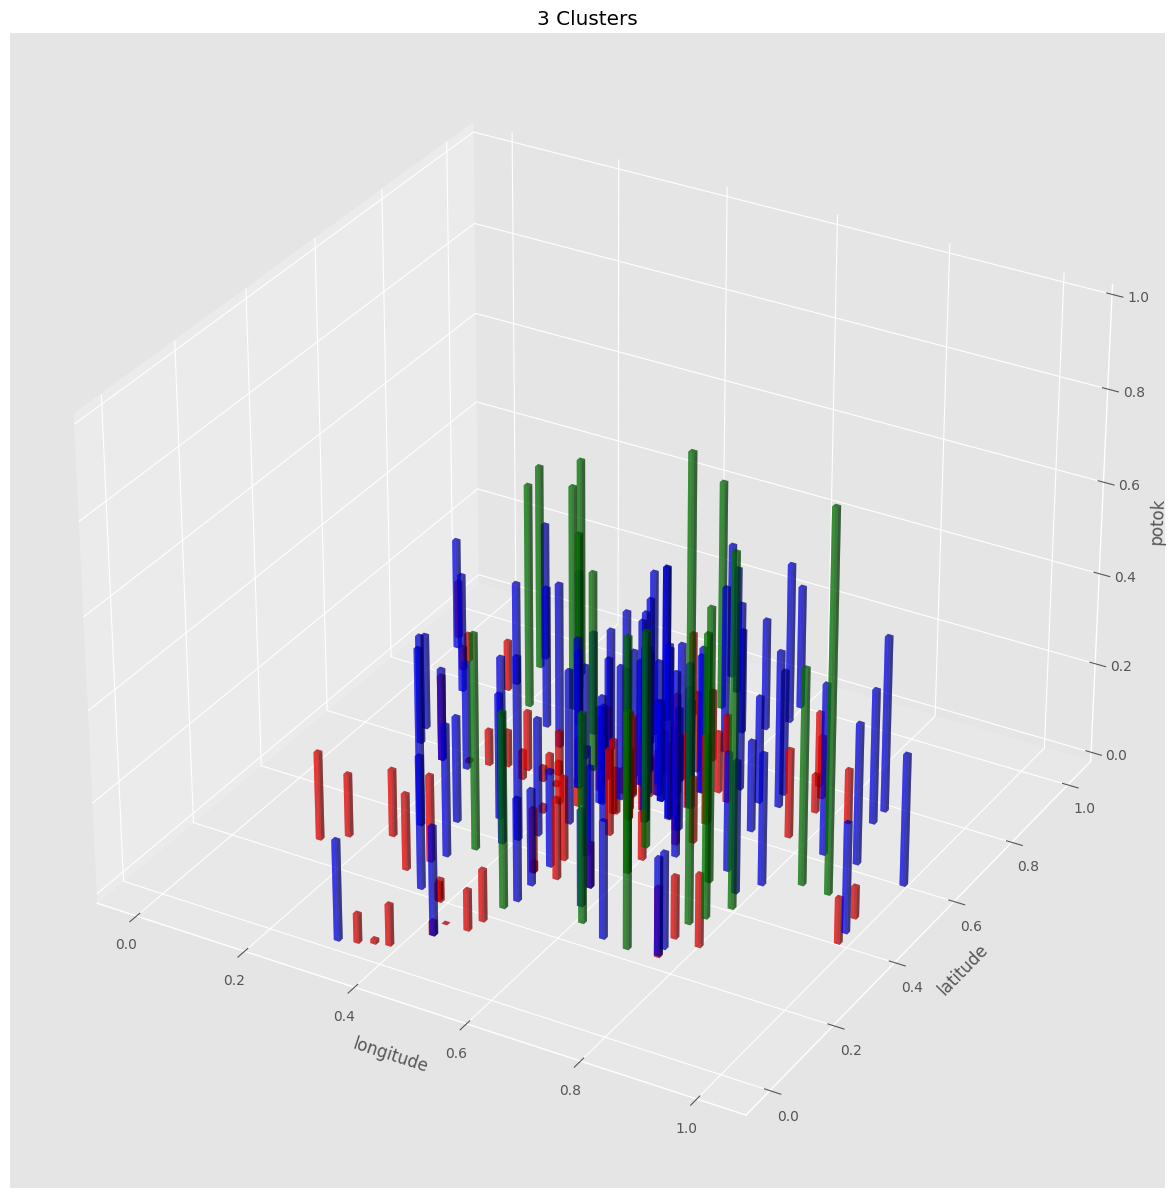

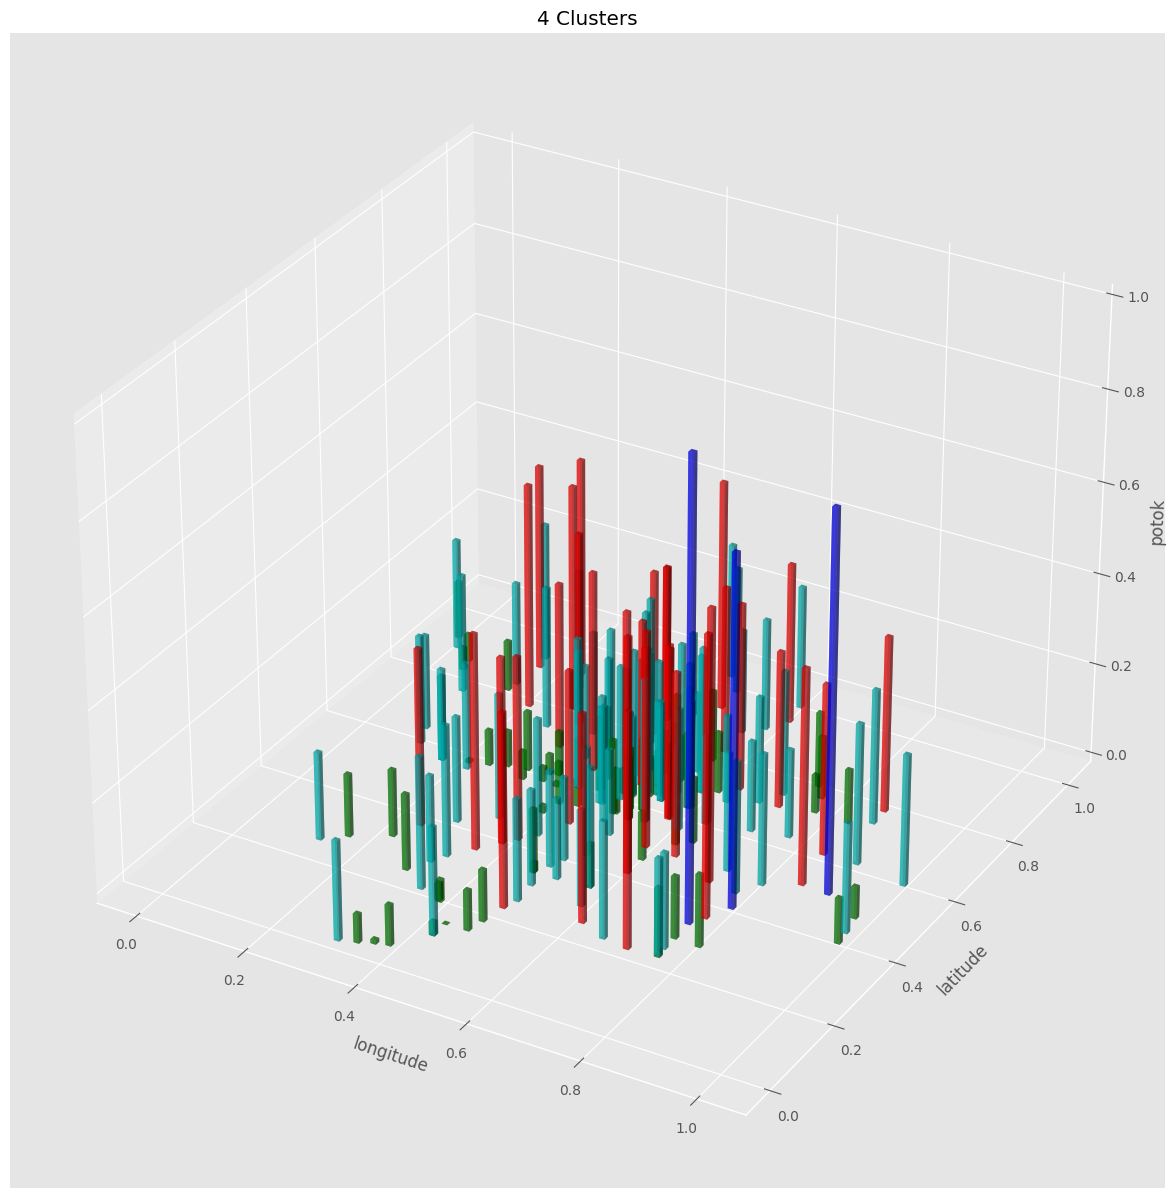

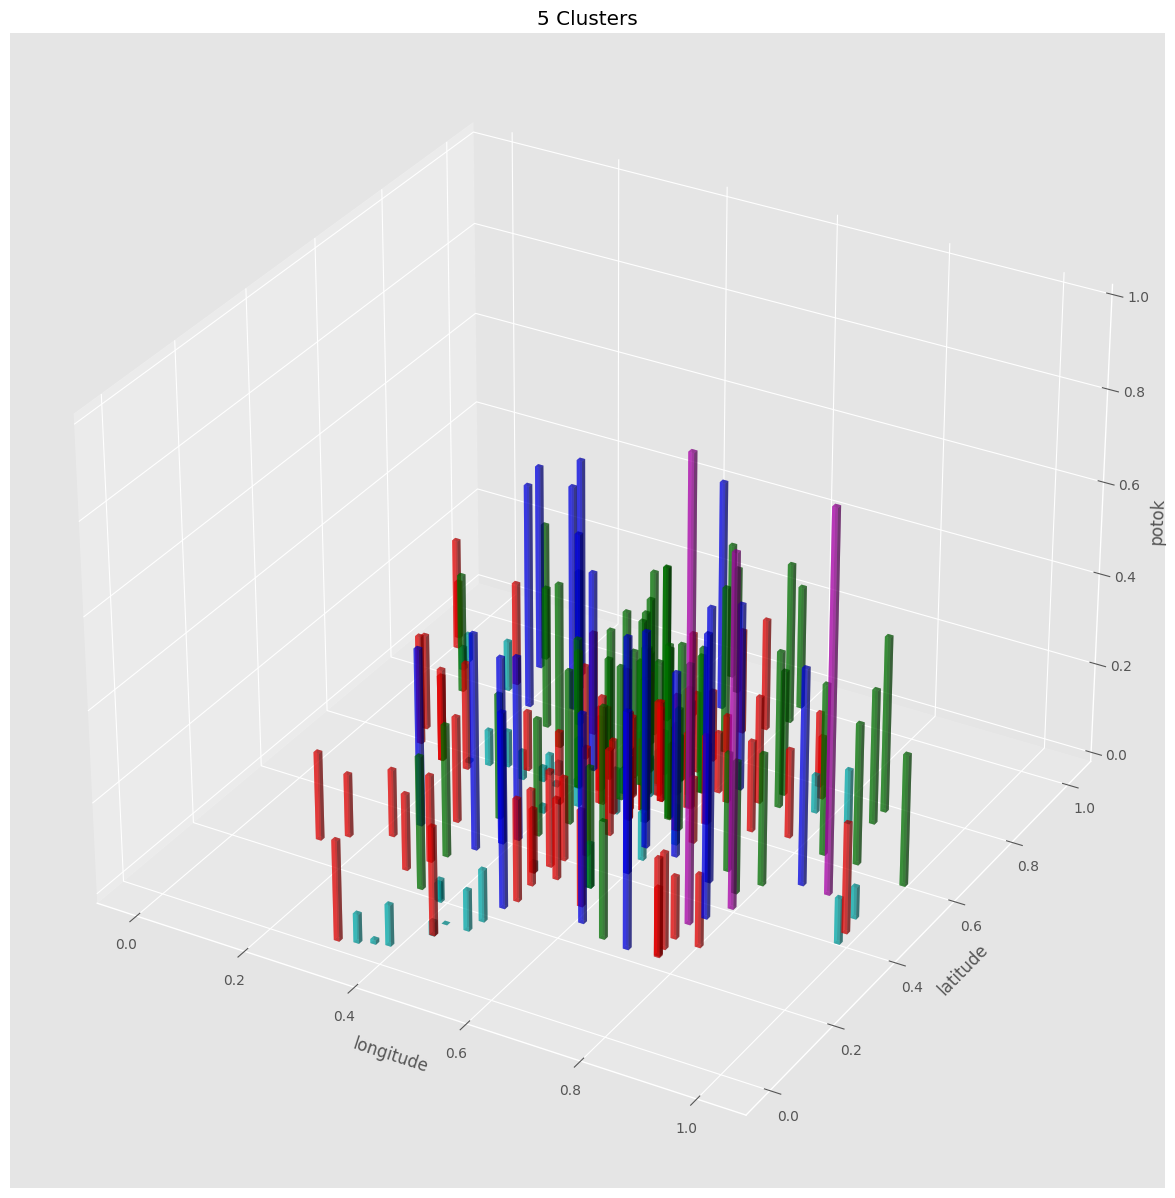

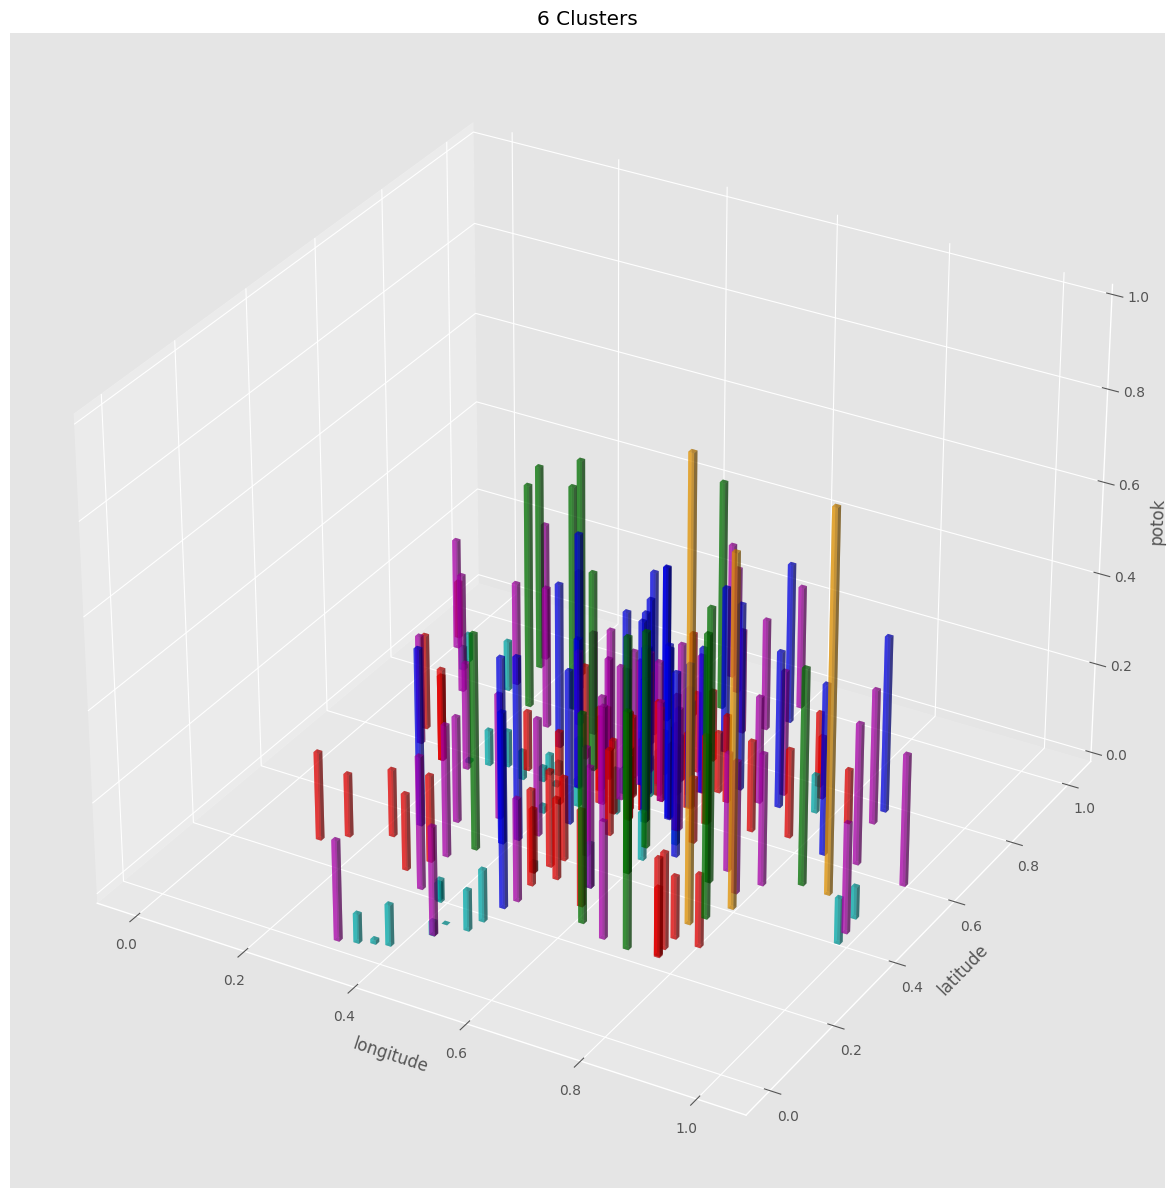

In [11]:
colors = ['r', 'g', 'b', 'c', 'm', '#FFA500']

for i in range(2, 7):
    model = KMeans(n_clusters=i, random_state=111, n_init=100, max_iter=10000)
    model.fit(first_df)

    first_df[f'{i}_clusters'] = model.labels_

    cluster_centers = model.cluster_centers_  # Центры кластеров для определения цветов

    threedee = plt.figure(figsize=(15, 15)).add_subplot(projection='3d')

    for j in range(len(standard_df)):
        x = standard_df["longitude"][j]
        y = standard_df["latitude"][j]
        z = standard_df["potok"]
        cluster_label = model.labels_[j]
        threedee.bar3d(x, y, 0, 0.01, 0.01, z[j], color=colors[cluster_label], alpha=0.5)

    threedee.set_xlabel('longitude')
    threedee.set_ylabel('latitude')
    threedee.set_zlabel('potok')
    threedee.set_title(f'{i} Clusters')
    plt.show()

Увы, визуализация в трёх осях достаточно плохо считывается. Построим 2d-диаграмму, где от пассажиропотока будет зависеть толщина точки:

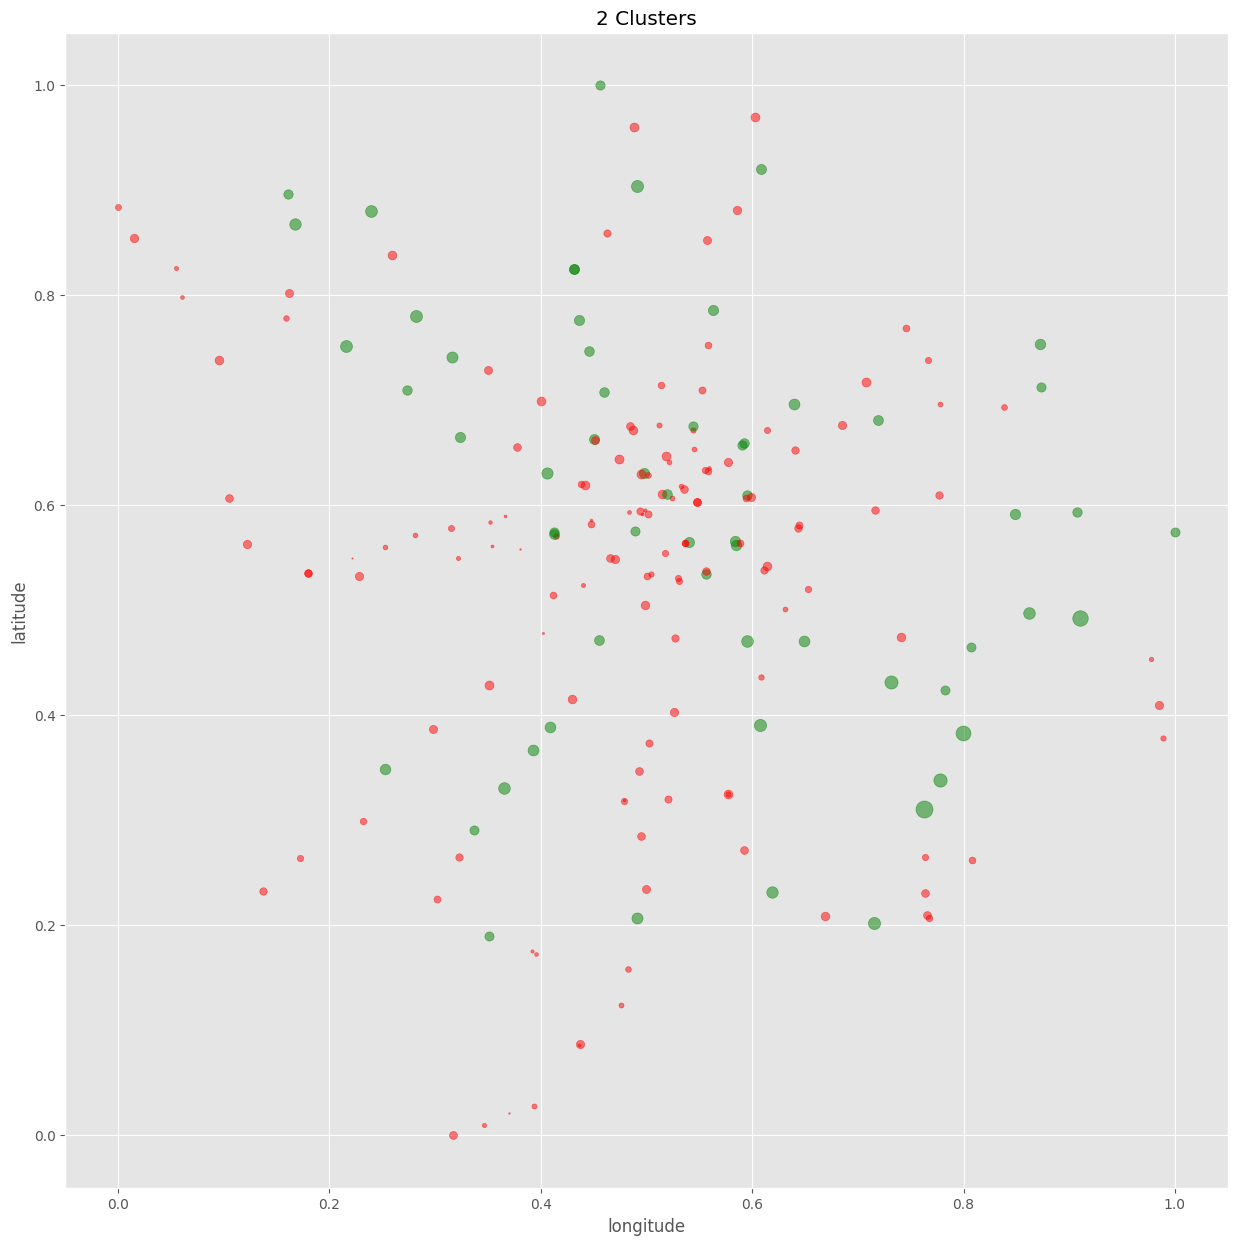

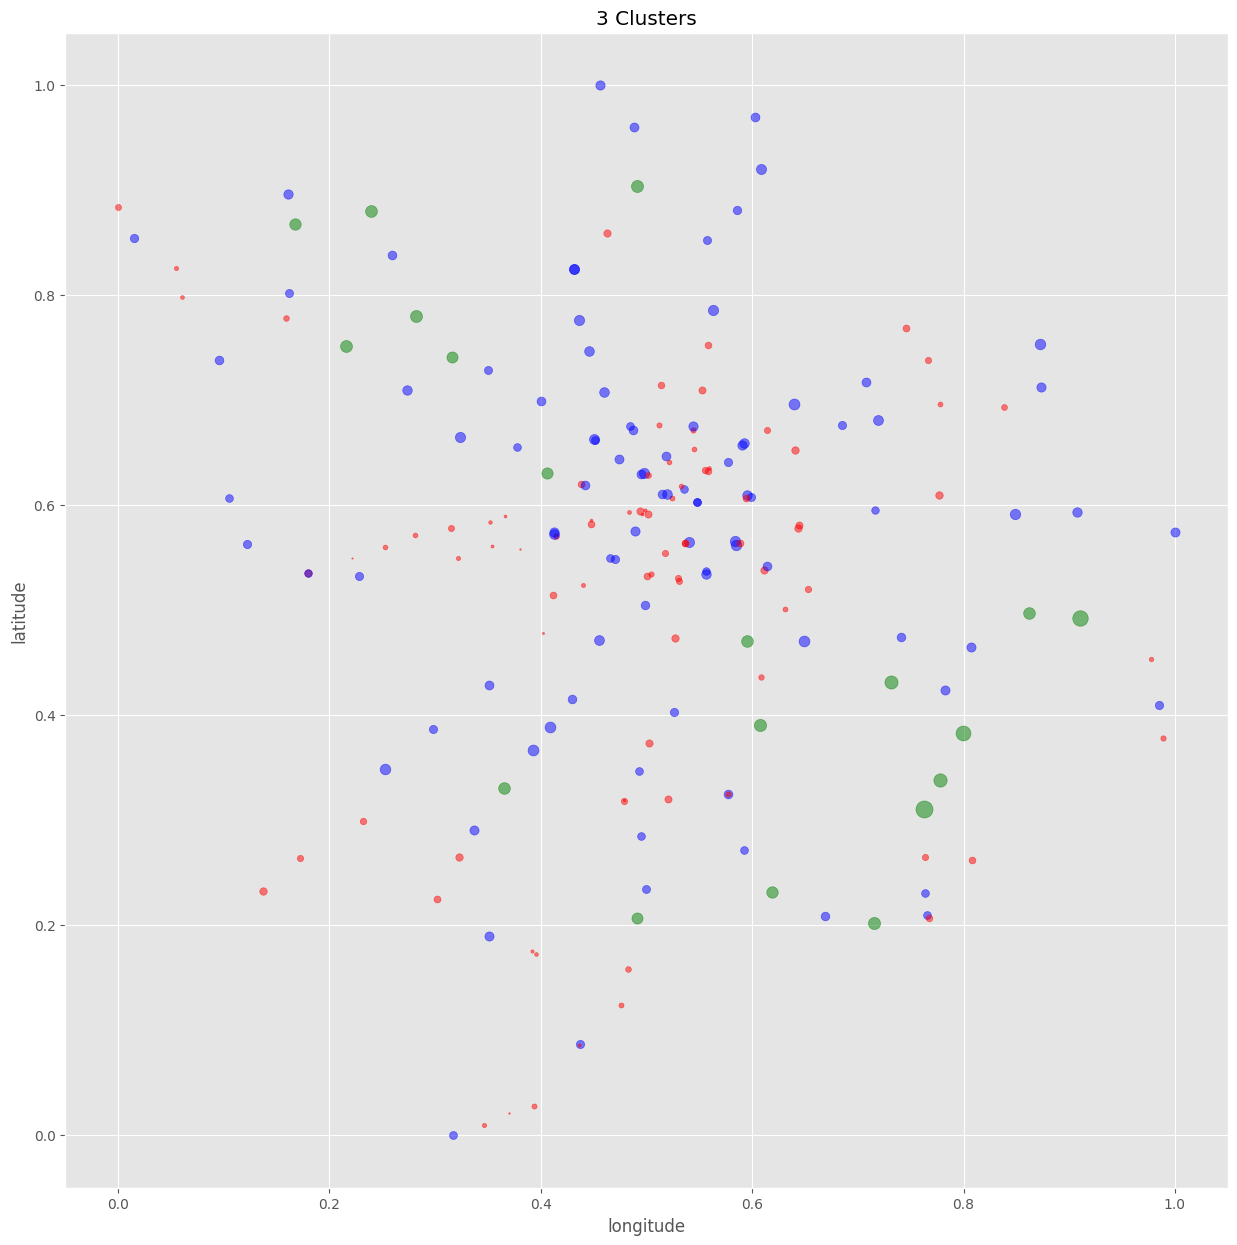

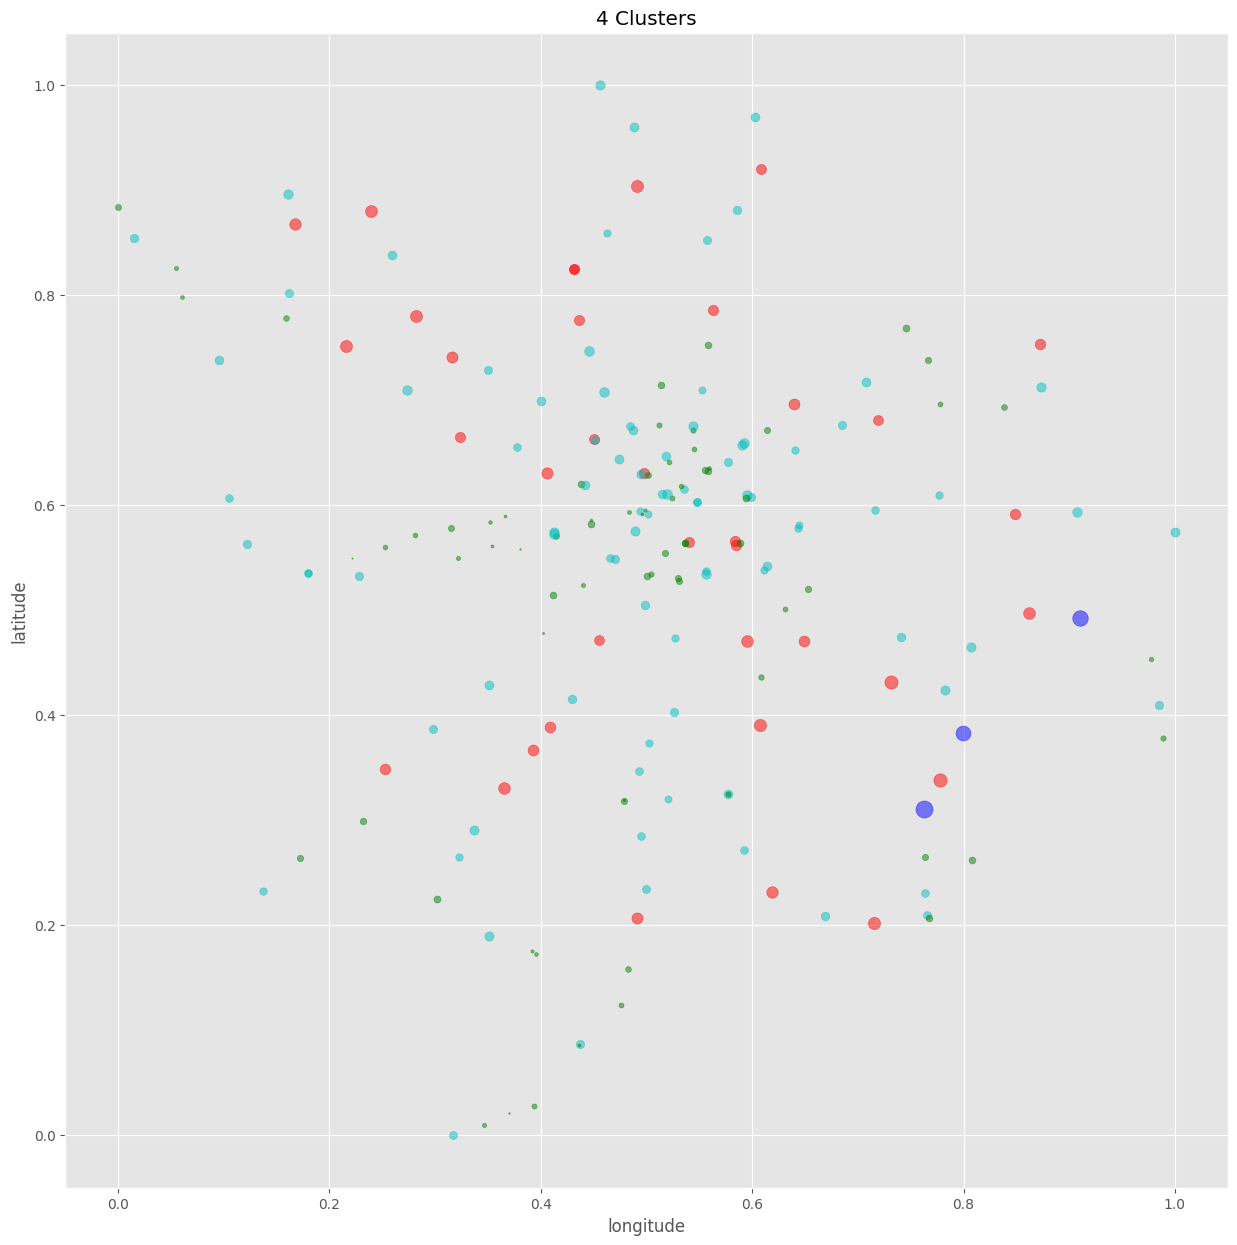

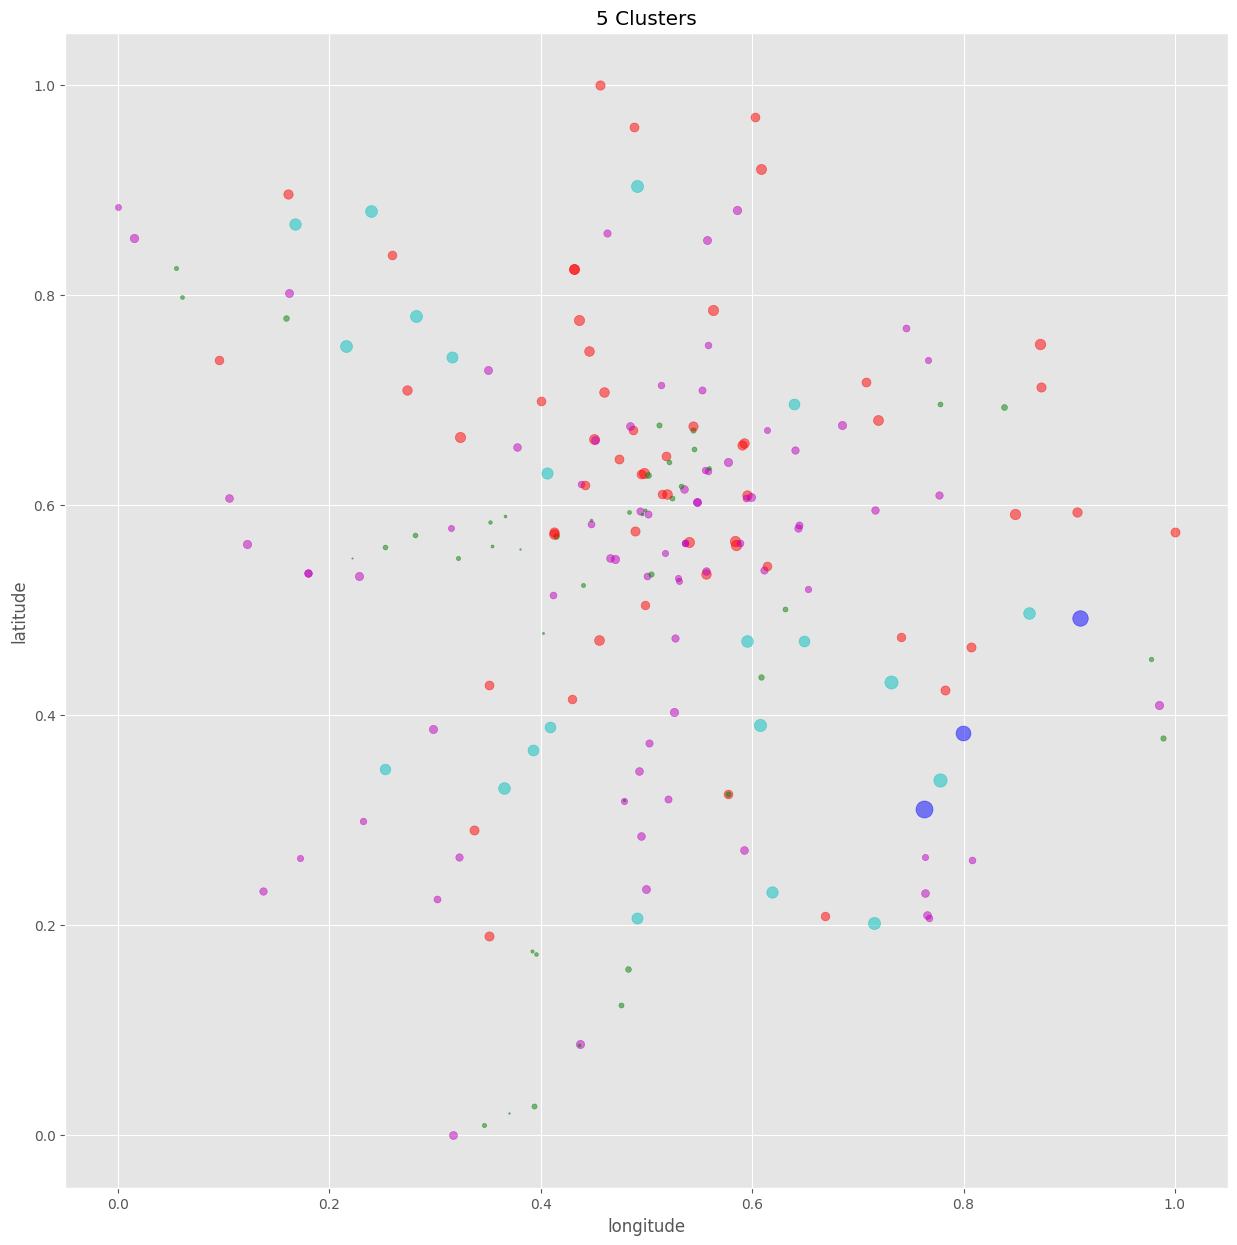

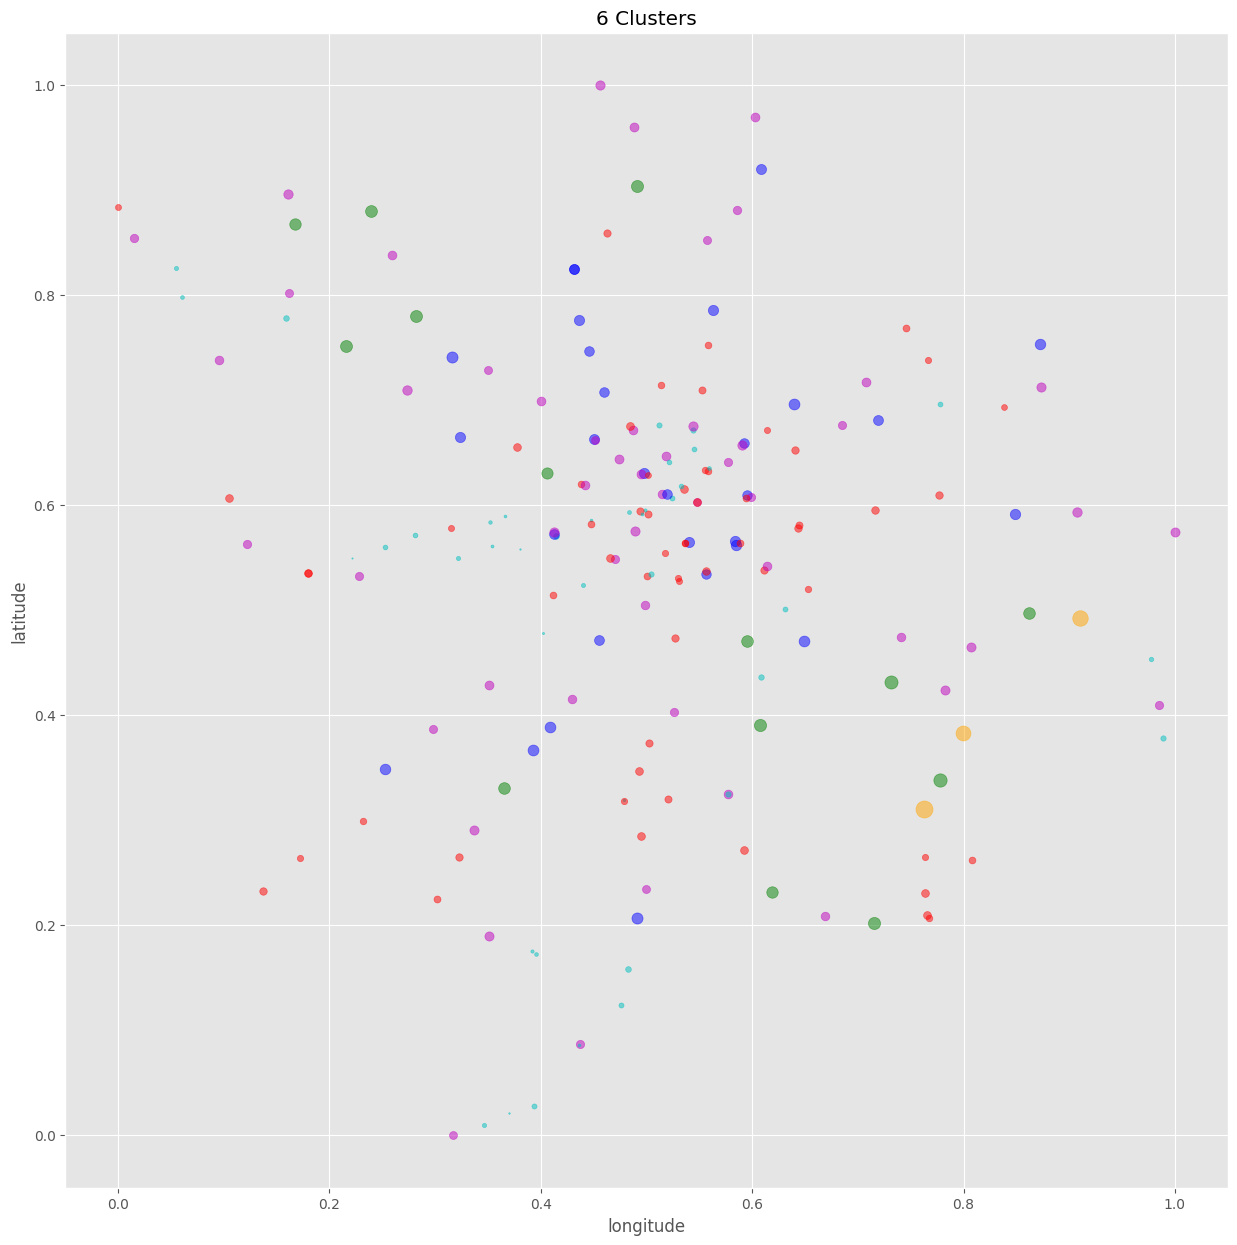

In [12]:
colors = ['r', 'g', 'b', 'c', 'm', '#FFA500']

for i in range(2, 7):
    model = KMeans(n_clusters=i, random_state=111, n_init=100, max_iter=10000)
    model.fit(first_df)

    first_df[f'{i}_clusters'] = model.labels_

    cluster_centers = model.cluster_centers_  # Центры кластеров для определения цветов

    plt.figure(figsize=(15, 15))

    for j in range(len(standard_df)):
        x = standard_df["longitude"][j]
        y = standard_df["latitude"][j]
        z = standard_df["potok"][j]
        cluster_label = model.labels_[j]
        plt.scatter(x, y, s=z*150, color=colors[cluster_label], alpha=0.5)

    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title(f'{i} Clusters')
    plt.show()

Другое дело! Теперь данные гораздо нагляднее.
Что же мы имеем? Во-первых, моя нулевая гипотеза не подтвердилась: самые загруженные станции не обязательно находятся в центре. На разбиении по 6 кластерам видны три станции глубоко в спальных районах *(по карте это "Выхино", "Люблино" и "Марьино")*. Во-вторых, данные довольно сложно интерпретировать только исходя из карты.

По построенным моделям можно предположить, что разбиения на 3, 4, 5 кластеров являются наиболее удачными и интерпретируемыми. Более мелкое разбиение размывает четкие границы кластеров. Постараемся предложить интерпретацию для каждого из 3 вариантов.

# Оценка модели и результатов

Проведем финальную кластеризацию и интерпретируем результаты

In [13]:
first_df.groupby('3_clusters')[['potok', 'latitude', 'longitude']].mean()

potok   latitude  longitude
3_clusters                                     
0            21385.057471  55.720316  37.602018
1           100415.789474  55.724518  37.631974
2            52155.913978  55.747760  37.612467

При разбиении на три кластера интерпретация самая простая. Для того чтобы понять смысл координаты, найдём эти точки на Яндекс.Картах и воспользуемся тем предположением, что в каком-то смысле Москва похожа на мишень в дартсе: самый центр - рабочие/деловые районы - спальные районы.
**Поэтому усреднённая координата показывает только удалённость от Кремля.**
*   Нулевой кластер. Координата бьёт в район [Нескучного сада](https://yandex.ru/maps/213/moscow/?ll=37.602625%2C55.720352&mode=search&sll=37.602018%2C55.720316&text=55.720316%2C37.602018&z=16). Пассажиропоток низкий, значит, это второстепенные непопулярные станции ближе к рабочим районам.
*   Первый кластер. Средняя координата - [район м. Серпуховская](https://yandex.ru/maps/213/moscow/?ll=37.631712%2C55.724484&mode=search&sll=37.631974%2C55.724518&text=55.724518%2C37.631974&z=16). Станции, расположенные преимущественно в спальных районах, с повышенным пассажиропотоком.
*   Второй кластер. Усреднённая координата - [Кремлёвская набережная](https://yandex.ru/maps/213/moscow/?ll=37.617083%2C55.748075&mode=search&sll=37.612467%2C55.747760&text=55.747760%2C37.612467&z=16). Средний пассажиропоток - станции в центре, пользующиеся равномерной популярностью у москвичей. Возможно, даже пересадочные.

In [14]:
first_df.groupby('4_clusters')[['potok', 'latitude', 'longitude']].mean()


potok   latitude  longitude
4_clusters                                     
0            77766.666667  55.750139  37.617153
1            18622.222222  55.718704  37.600432
2           157600.000000  55.680463  37.774259
3            45519.318182  55.740704  37.608763

* Кластер 0: [Кремль](https://yandex.ru/maps/213/moscow/?ll=37.616962%2C55.750013&mode=search&sll=37.617153%2C55.750139&text=55.750139%2C37.617153&z=16). Станции с большим пасспотоком, опоясывающие центр. Это кластер 2 из предыдущего случая.

*   Кластер 1: [У Нескучного сада](https://yandex.ru/maps/213/moscow/?ll=37.600029%2C55.718836&mode=search&sll=37.600432%2C55.718704&text=55.718704%2C37.600432&z=16). Низкий пассажиропоток. Это кластер 0 из предыдущего случая.

А кластер 1 из предыдущего случая разбился на два новых кластера:
*   Кластер 2: [Спальный район Люблино](https://yandex.ru/maps/213/moscow/?ll=37.770637%2C55.678803&mode=search&sll=37.774259%2C55.680463&text=55.680463%2C37.774259&z=16). Станции с запредельным пасспотоком в рабочих кварталах.
*   Кластер 3: [Берсеневская набережная](https://yandex.ru/maps/213/moscow/?ll=37.609263%2C55.740654&mode=search&sll=37.608763%2C55.740704&text=55.740704%2C37.608763&z=16). Центр, средний пассажиропоток.


In [15]:
first_df.groupby('5_clusters')[['potok', 'latitude', 'longitude']].mean()


potok   latitude  longitude
5_clusters                                     
0            56676.363636  55.765237  37.625566
1            12679.545455  55.711787  37.589886
2           157600.000000  55.680463  37.774259
3            85952.380952  55.725370  37.602407
4            35078.947368  55.727555  37.605369

*   Кластер 0 - [Бульварное кольцо](https://yandex.ru/maps/213/moscow/?ll=37.625720%2C55.765205&mode=search&sll=37.625566%2C55.765237&text=55.765237%2C37.625566&z=16). Станции со средним пасспотоком, центр.
*   Кластер 1 - [Ленинский проспект, Третье транспортное кольцо](https://yandex.ru/maps/213/moscow/?ll=37.589832%2C55.711539&mode=search&sll=37.589886%2C55.711787&text=55.711787%2C37.589886&z=16). Низкий пассажиропоток, не самый центр.
*   Кластер 2 - [Спальный район Люблино](https://yandex.ru/maps/213/moscow/?ll=37.770637%2C55.678803&mode=search&sll=37.774259%2C55.680463&text=55.680463%2C37.774259&z=16). Станции с запредельным пасспотоком в рабочих кварталах.
* Кластер 3 - [Около Парка Горького](https://yandex.ru/maps/213/moscow/?ll=37.602364%2C55.725356&mode=search&sll=37.602407%2C55.725370&text=55.725370%2C37.602407&z=16). Поток выше среднего, центр.
*   Кластер 4 - [Парк Горького](https://yandex.ru/maps/213/moscow/?ll=37.605283%2C55.727592&mode=search&sll=37.605369%2C55.727555&text=55.727555%2C37.605369&z=16). Станции с маленьким пасспотоком, равномерно распределённые по всей сети.

Мне кажется, достаточно выделить 3-4 кластера, чтобы полно описать пассажиропоток на станциях московского метро.

# Кластеризация "глубина-пассажиропоток-дата постройки"
Теперь попробуем найти зависимость между глубиной заложения, датой постройки и пассажиропотоком. Расположим точки в координатах "глубина-дата постройки", а пассажиропоток будем обозначать толщиной точки.

Нулевая гипотеза: глубокие станции были построены достаточно поздно, потому что в 1930-х годах технологии не позволяли углубиться слишком сильно. На старых станциях пассажиропоток больше, потому что они строились в первую очередь для обслуживания больших масс населения. Пассажиропоток с глубиной не коррелирует.

In [16]:
second_df = float_df.copy()
second_df = second_df[['potok', 'newness', 'depth']]

K = range(1, 11)
models = [KMeans(n_clusters = k, random_state = 111, n_init = 100, max_iter = 10000).fit(second_df) for k in K]
dist = [model.inertia_ for model in models]

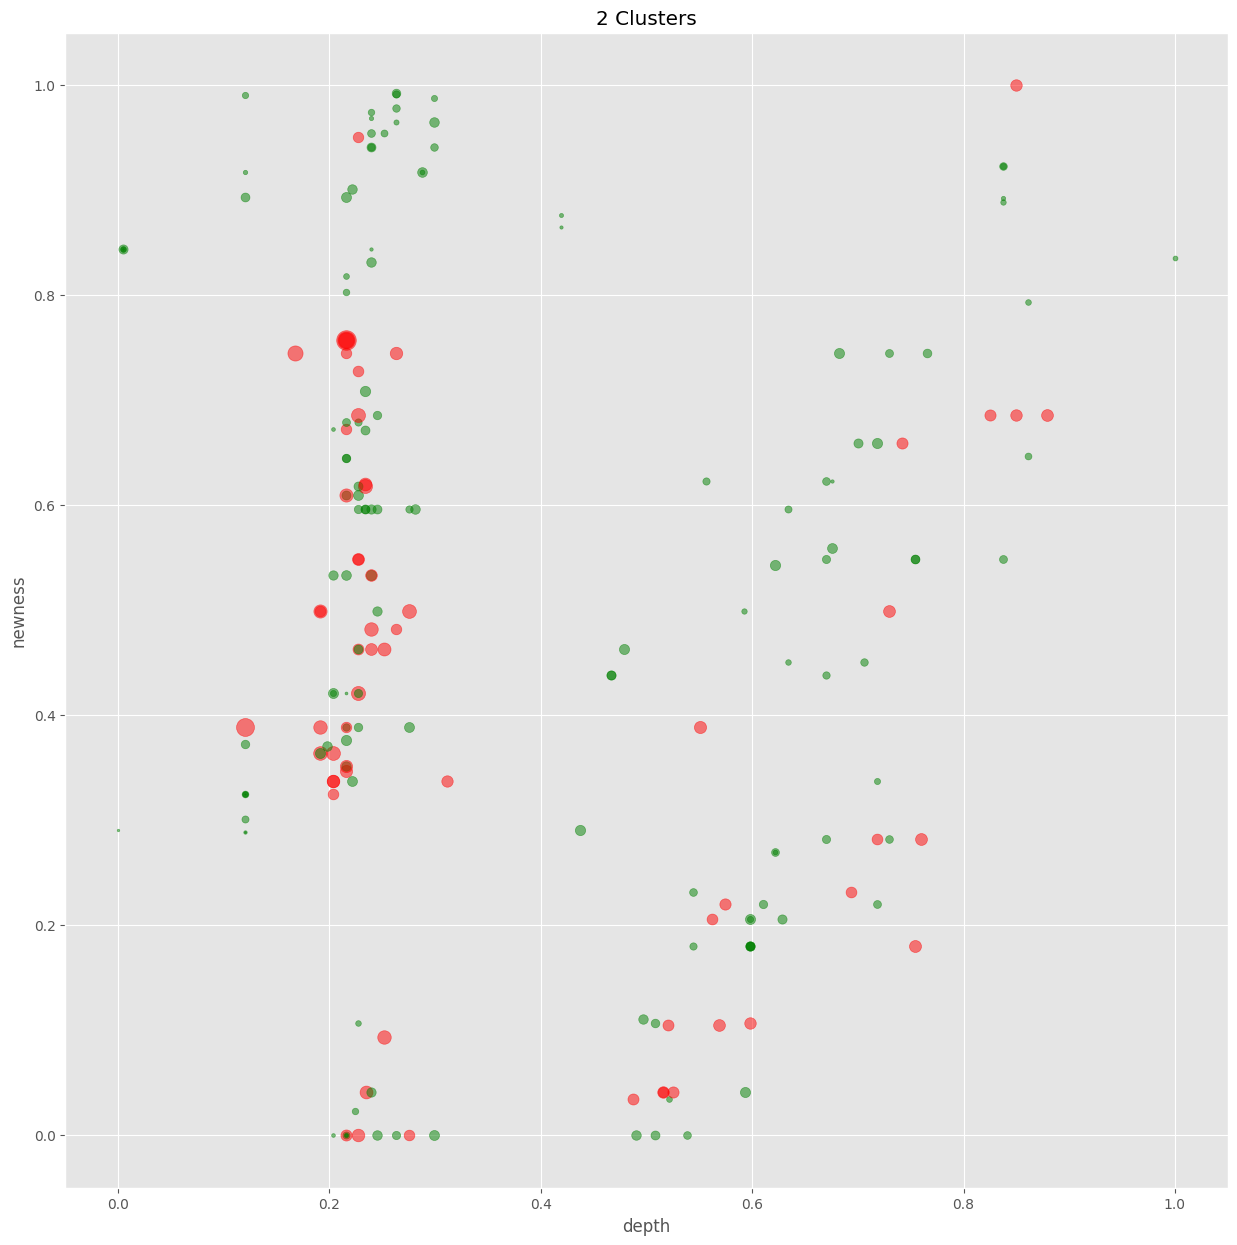

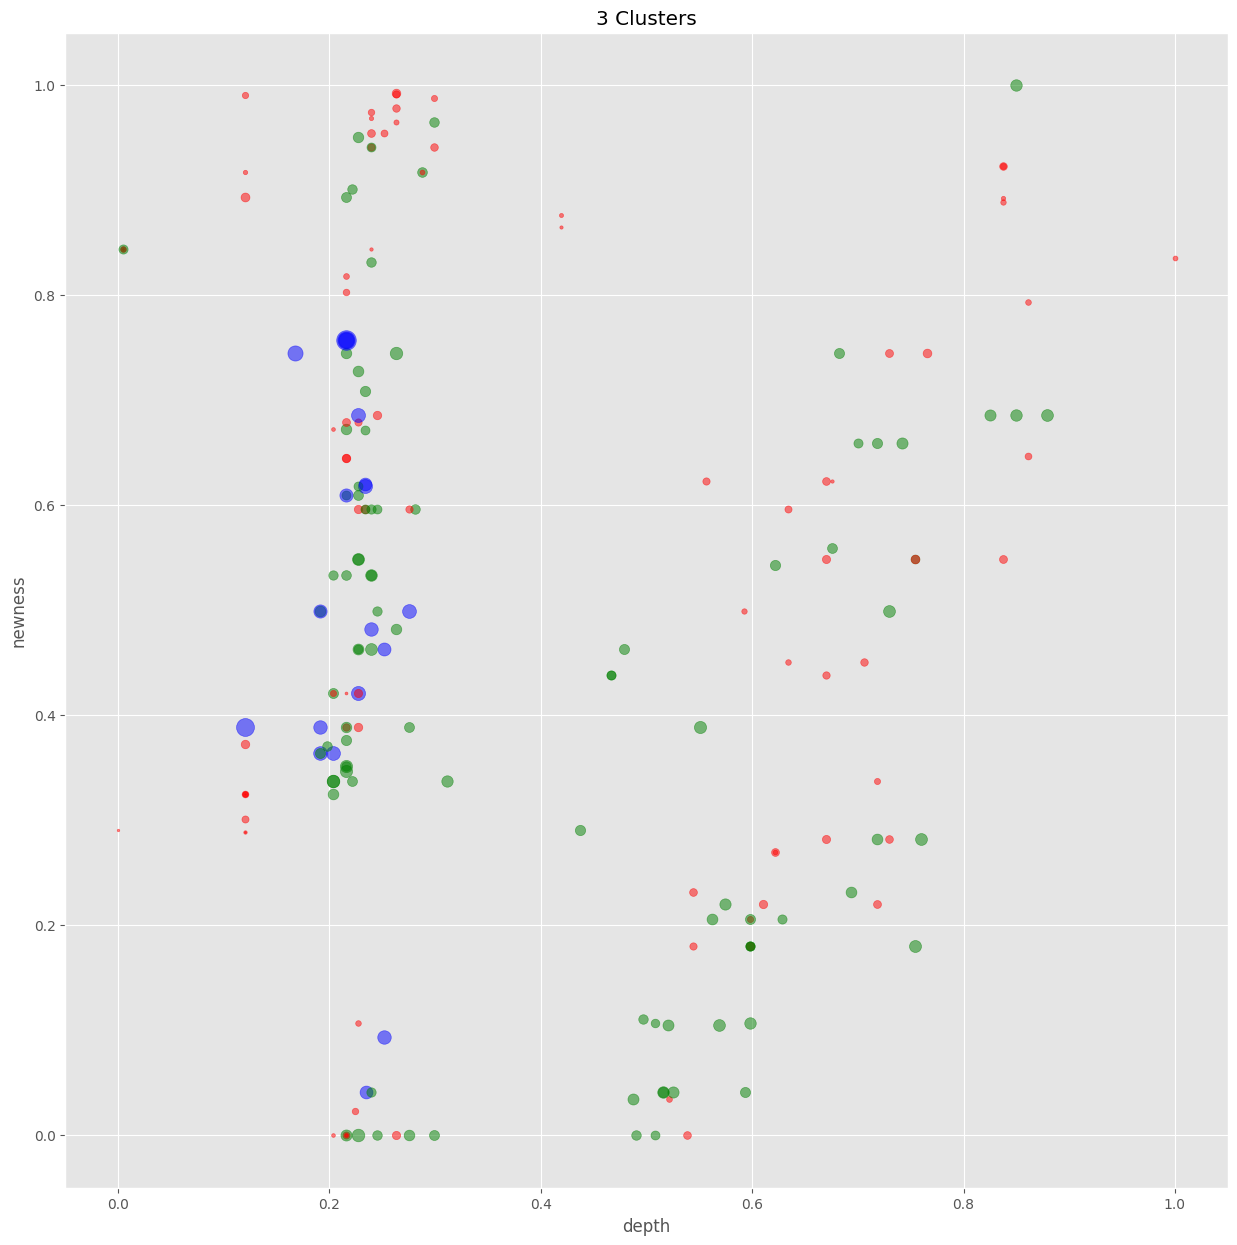

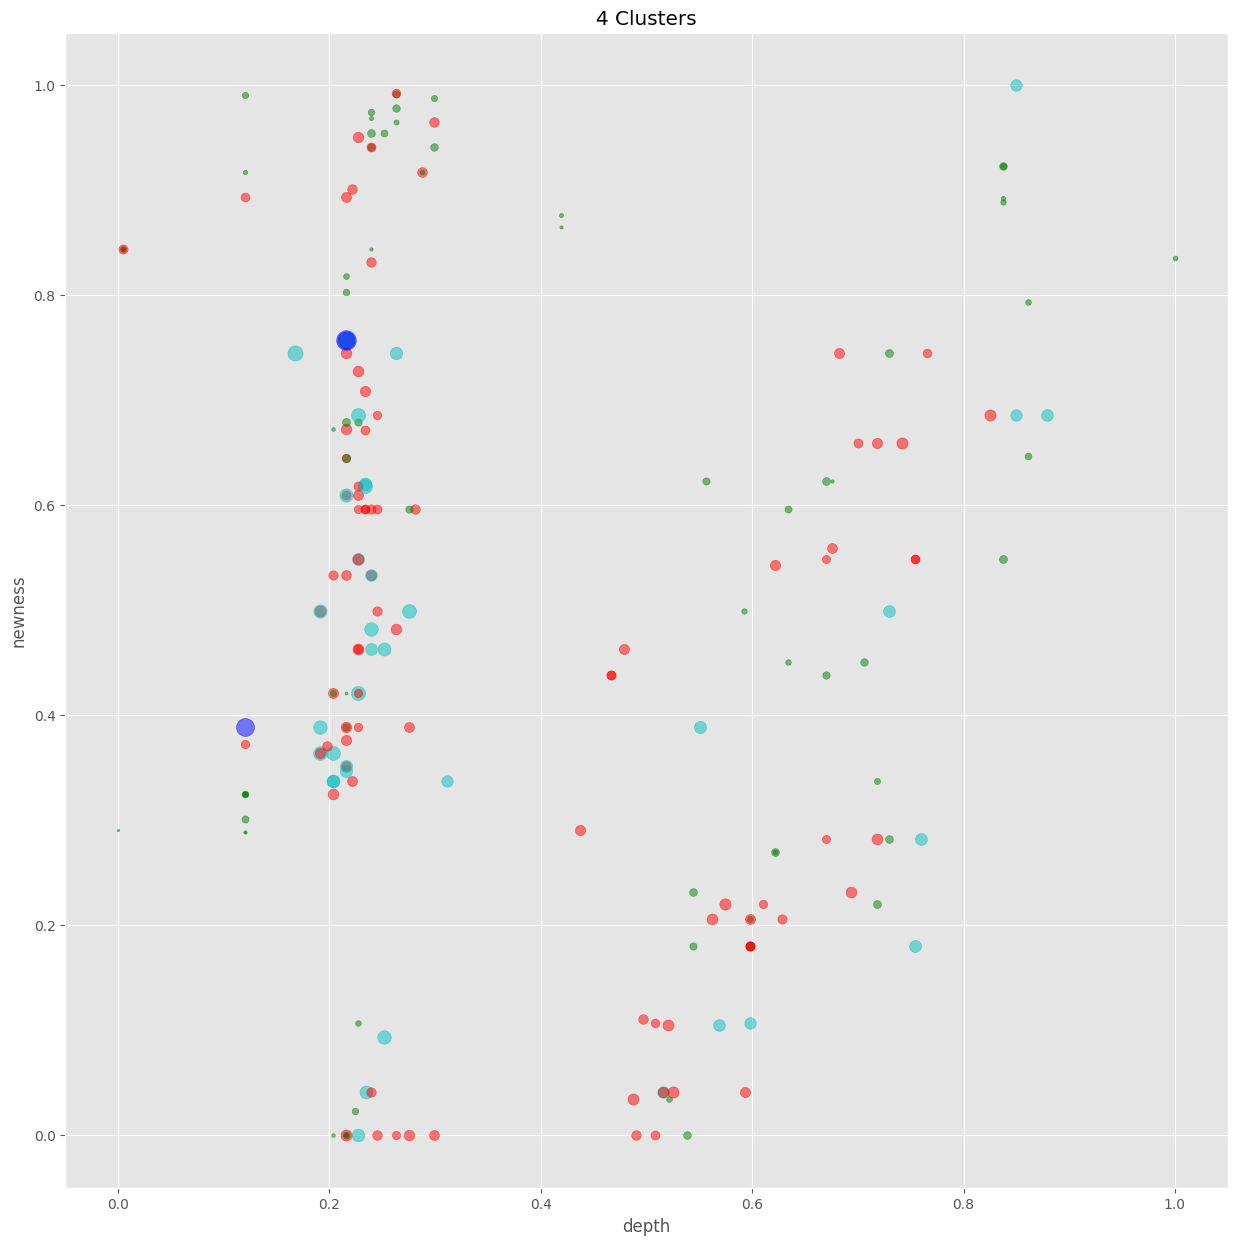

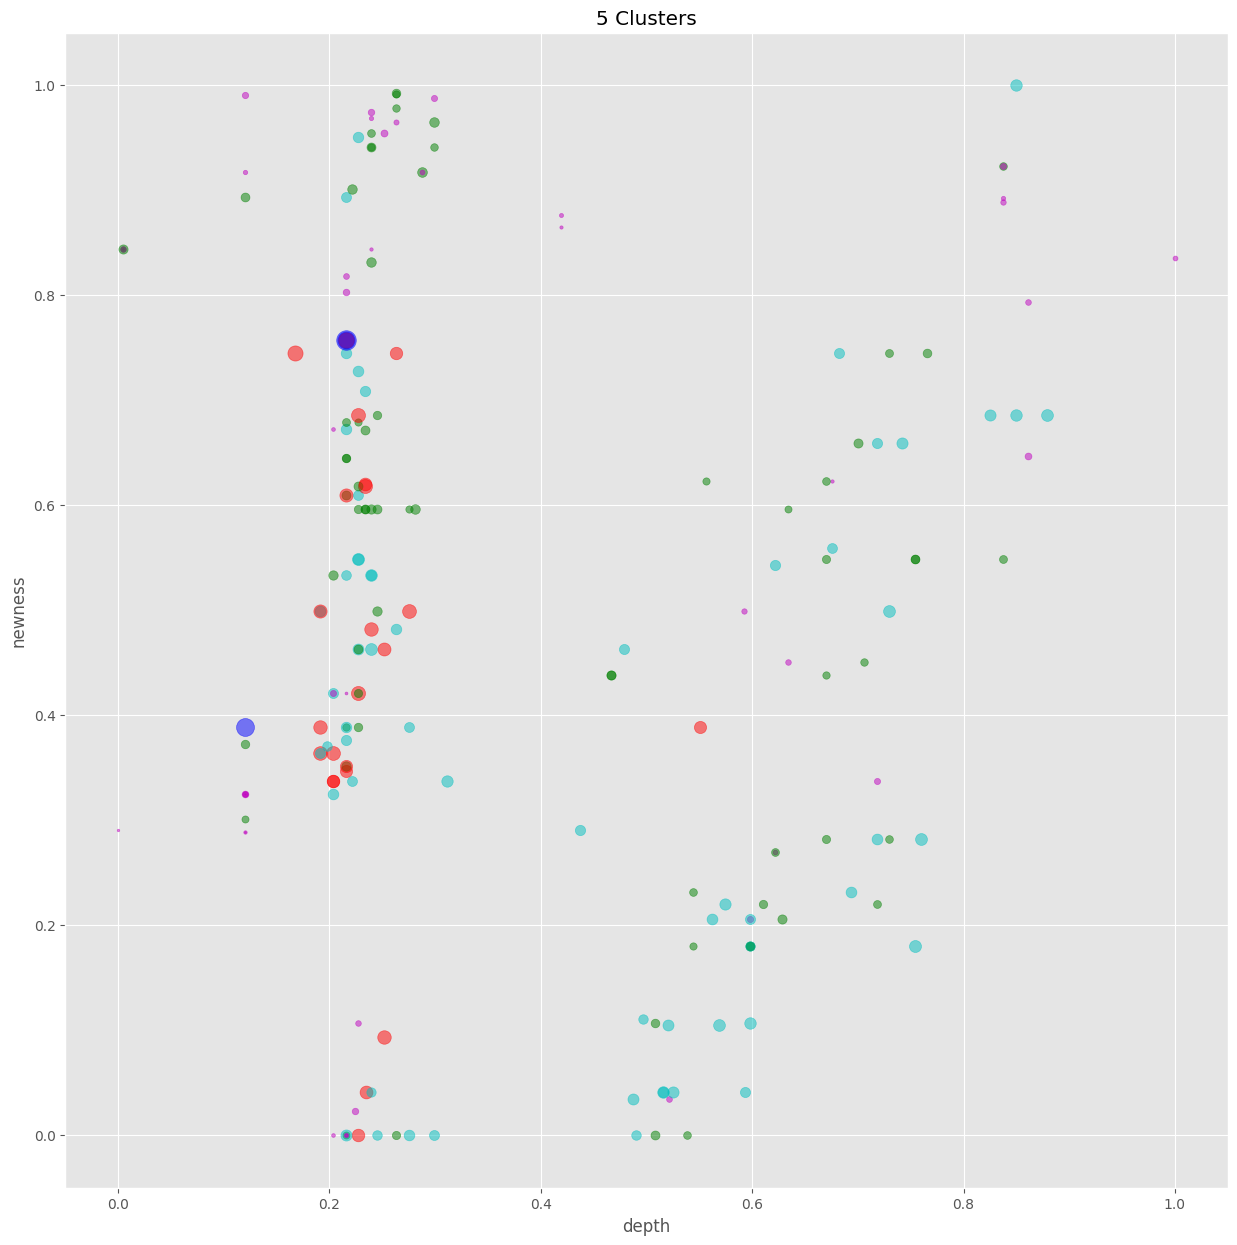

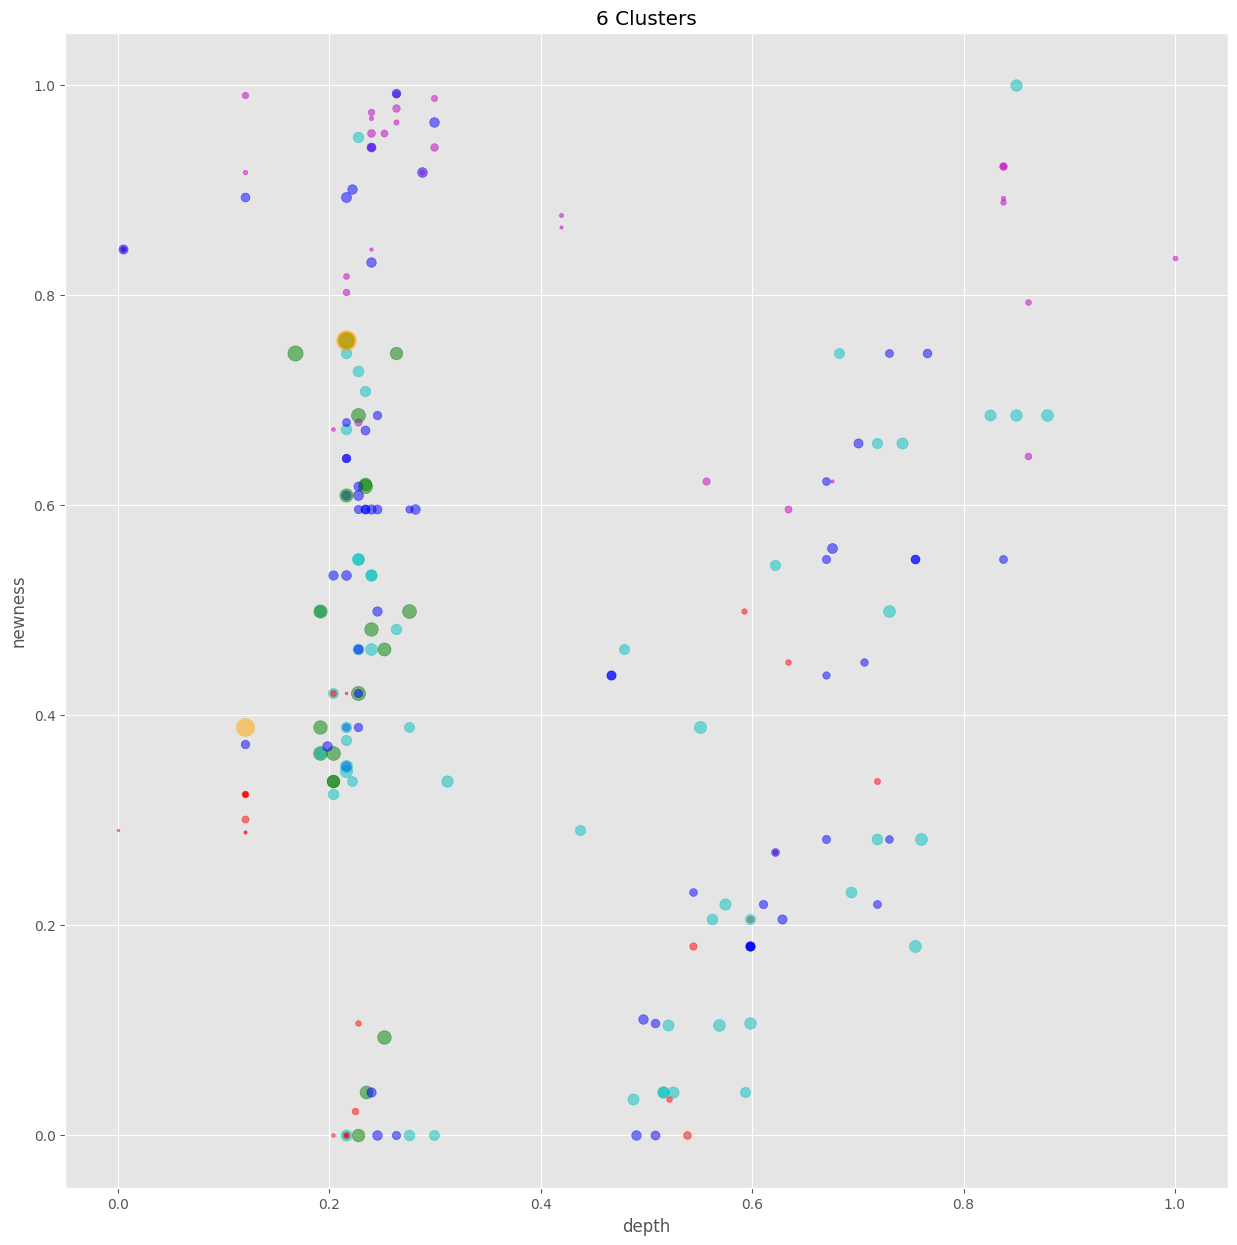

In [42]:
colors = ['r', 'g', 'b', 'c', 'm', '#FFA500']

for i in range(2, 7):
    model = KMeans(n_clusters=i, random_state=111, n_init=100, max_iter=10000)
    model.fit(second_df)

    second_df[f'{i}_clusters'] = model.labels_

    cluster_centers = model.cluster_centers_  # Центры кластеров для определения цветов

    plt.figure(figsize=(15, 15))

    for j in range(len(standard_df)):
        x = standard_df["depth"][j]
        y = standard_df["newness"][j]
        z = standard_df["potok"][j]
        cluster_label = model.labels_[j]
        plt.scatter(1-x, y, s=z*200, color=colors[cluster_label], alpha=0.5)


    plt.xlabel('depth')
    plt.ylabel('newness')
    plt.title(f'{i} Clusters')
    plt.show()

Что мы видим по получившимся картинкам? Во-первых, большая часть станций мелкого заложения. Во-вторых, на глубоких станциях, как правило, меньше народу. В остальном нулевая гипотеза подтвердилась:

# Оценка второй модели

In [26]:
second_df.groupby('3_clusters')[['depth', 'newness', 'potok']].mean()

depth       newness          potok
3_clusters                                        
0          -22.604598  16712.770115   21408.045977
1          -23.218280  12761.602151   52134.408602
2           -8.031579  14948.210526  100415.789474

Переведём полученные усреднённые даты открытия в даты:

In [31]:
import datetime
date_1 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 16713)
date_2 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 12762)
date_3 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 14948)
print(date_1, date_2, date_3)

1981-02-15 00:00:00 1970-04-23 00:00:00 1976-04-17 00:00:00


Разбиение на три кластера, как оказалось, не даёт результатов по глубине заложения, но довольно чётко описывает дату открытия относительно пасспотока.

* Кластер 0: станции с небольшим пассажиропотоком, открытые в среднем в 1981 году. Характерно, что эта дата попадает в эпоху "брежневского застоя", когда станции открывались быстрыми темпами и без особой нужды в них.
* Кластер 1: станции со средним пассажиропотоком, включая наиболее старые (и самые нужные по состоянию на 1935 год)
* Кластер 2: станции с большим пассажиропотоком, средняя дата для которых приходится на активное строительство московских жилых кварталов.

Трёхкластерное разбиение оказалось нерепрезентативным. Идём дальше.

In [33]:
second_df.groupby('4_clusters')[['depth', 'newness', 'potok']].mean()

depth       newness          potok
4_clusters                                        
0          -21.507955  13474.034091   45519.318182
1          -22.883333  16919.583333   18622.222222
2           -5.333333  18855.333333  157600.000000
3          -20.061111  12899.027778   77766.666667

In [35]:
date_1 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 13474)
date_2 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 16920)
date_3 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 18855)
date_4 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 12899)
print(date_1, date_2, date_3, date_4)

1972-04-04 00:00:00 1981-09-10 00:00:00 1986-12-28 00:00:00 1970-09-07 00:00:00


* Кластер 0: станции со средним пасспотоком, открытые в среднем в 1972 году, мелкое заложение.
* Кластер 1: станции чуть поглубже с низким пасспотоком, открытые в среднем в 1981 году.
* Кластер 2: станции с запредельным пасспотоком *(всё те же "Марьино", "Люблино" и "Выхино")* неглубокого заложения. Открыты ближе к развалу СССР *(на деле "Выхино" открыта в 1966 г., а две остальные - в 1996 г.)*
* Кластер 3: станции с пасспотоком выше среднего, глубина заложения средняя, открыты (усреднённо) в 1970 году.

In [37]:
second_df.groupby('5_clusters')[['depth', 'newness', 'potok']].mean()

depth       newness          potok
5_clusters                                        
0           -9.721739  13127.347826   84634.782609
1          -23.704412  16005.455882   34329.411765
2           -5.333333  18855.333333  157600.000000
3          -26.215000  11463.966667   54720.000000
4          -18.980000  17558.933333   12931.111111

In [38]:
date_1 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 13127)
date_2 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 16005)
date_4 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 11463)
date_5 = datetime.datetime.strptime( "15/05/1935" , "%d/%m/%Y" ) + datetime.timedelta(days = 17558)
print(date_1, date_2, date_4, date_5)

1971-04-23 00:00:00 1979-03-10 00:00:00 1966-10-02 00:00:00 1983-06-10 00:00:00


* Кластер 0: неглубокие, в среднем старые, станции с большим пассажиропотоком
* Кластер 1: глубина заложения больше среднего, а пасспоток - меньше среднего. Средняя дата открытия 1979 г.
* Кластер 2: аналогичен предыдущему пункту
* Кластер 3: довольно старые станции со средним пасспотоком и большой глубиной заложения
* Кластер 4: в среднем новые станции с маленьким пассажиропотоком, не выделяющиеся глубиной заложения

# Выводы
Как ни крути, в последнем пункте было довольно сложно объяснить смысл кластера. Каждый раз приходилось "натягивать карту на глобус" и искать закономерности, о которых среднее значение не знает (станции разбросаны по нашим графикам хаотично, и средняя дата практически ни о чём ни говорит).

Тогда приходим к заключению, что кластеризовать данные по пассажиропотоку и координате можно с достаточно логичными выводами, а вот пасспоток-глубина-дата на малое число кластеров разбить нельзя.